In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [5]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [6]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [7]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spol"], params["Spar"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [8]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [9]:
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

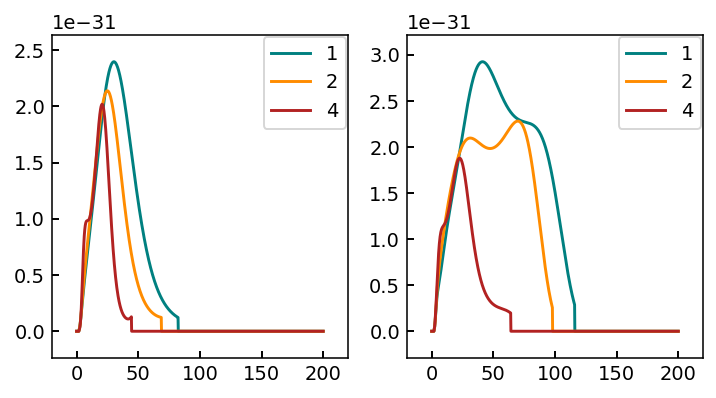

In [10]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [11]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

(-10.0, 200.0)

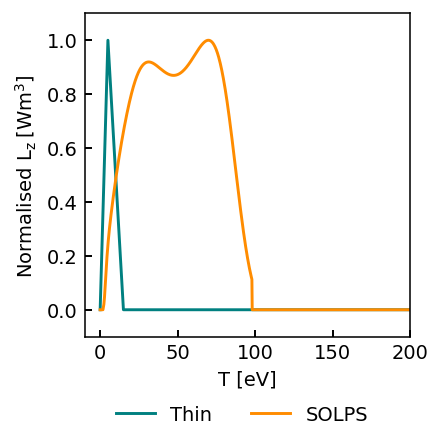

In [13]:
curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

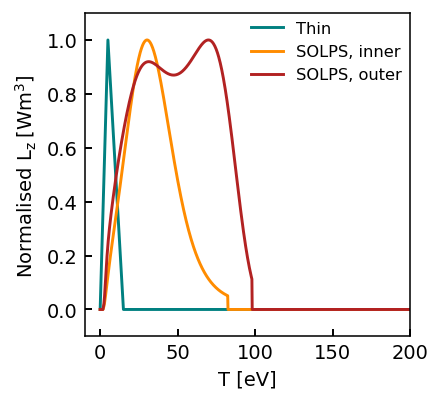

In [26]:
curves["set_inner"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["neTau"][1e20],
    # "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))

curves_plot = {
    "Thin" : curves["set_inner"]["Thin"],
    "SOLPS, inner" : curves["set_inner"]["SOLPS"],
    "SOLPS, outer" : curves["set_outer"]["SOLPS"],
}

for name, function in curves_plot.items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
ax.legend(fontsize = "small", loc = "upper right", bbox_to_anchor = (1,1), ncol = 1, frameon = False)
ax.set_xlim(-10,200)
fig.savefig(r"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\RadiationImpact_curves.pdf", format = "pdf")

# Profile grid

## Make profiles - outer

Text(0.5, 1.0, 'Profile shapes')

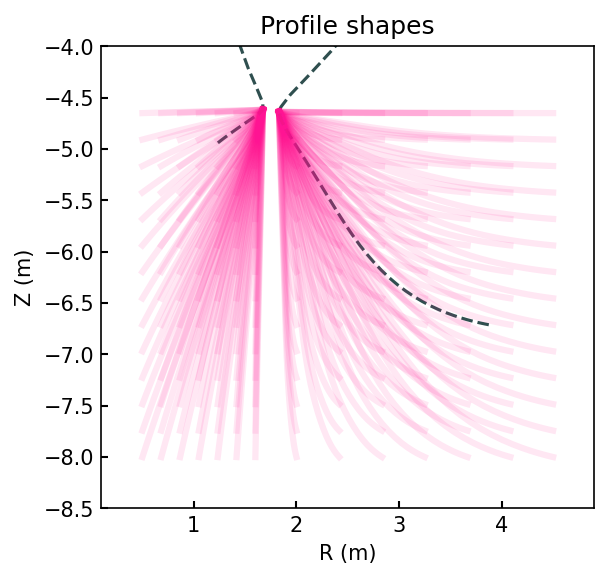

In [232]:
base_profile = dict(inner = eqb_alt['100MW_innerar_midplanepuff']["inner_lower"][sepadd_select["inner_lower"]], 
                    outer = eqb_alt['100MW_innerar_midplanepuff']["outer_lower"][sepadd_select["outer_lower"]])

res = 7
xpoints = dict(inner = np.linspace(0.5, 1.6, res), outer = np.linspace(2.0, 4.5, res))
ypoints = dict(inner = np.linspace(-4.65, -8, res*2), outer = np.linspace(-4.65, -8, res*2))
# xpoints = dict(inner = np.linspace(0.5, 1.6, res), outer = np.linspace(2.5, 3.5, res))
# ypoints = dict(inner = np.linspace(-4.65, -8, res), outer = np.linspace(-4.65, -6, res))


fig, ax = plt.subplots(dpi = 150)

profiles_constBpol = {}
for side in ["inner", "outer"]:
    profiles_constBpol[side] = {}
    for x in xpoints[side]:
        profiles_constBpol[side][x] = {}
        for y in ypoints[side]:
            p2 = base_profile[side].copy()
            offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], x, y)
            p2.offset_control_points(offsets, verbose = False)
            p2.recalculate_topology(constant_pitch = False, verbose = False)
            profiles_constBpol[side][x][y] = p2
        
    ax.plot(base_profile[side]["R"], base_profile[side]["Z"], ls = "--", c = "darkslategrey")

    for x in xpoints[side]:
        for y in ypoints[side]:
            profiles_constBpol[side][x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)
        
profiles_constBpitch = {}
for side in ["inner", "outer"]:
    profiles_constBpitch[side] = {}
    for x in xpoints[side]:
        profiles_constBpitch[side][x] = {}
        for y in ypoints[side]:
            p2 = base_profile[side].copy()
            offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], x, y)
            p2.offset_control_points(offsets, verbose = False)
            p2.recalculate_topology(constant_pitch = True, verbose = False)
            profiles_constBpitch[side][x][y] = p2

ax.set_ylim(-8.5, -4.0)
ax.set_aspect("equal")
ax.set_title("Profile shapes")

## Profile debug
Bpol vs Bpitch


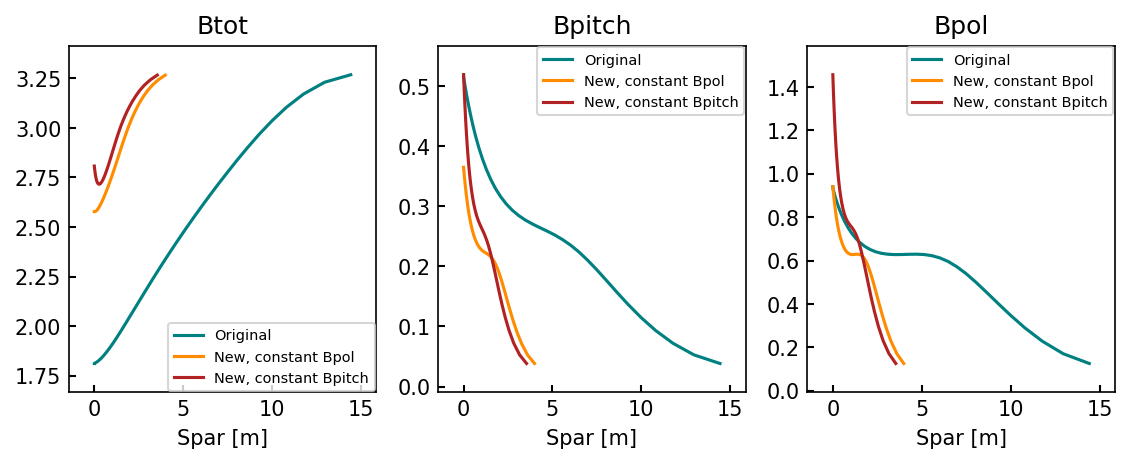

In [17]:
p2 = profiles_constBpol[side][2.50][-4.65]
p1 = base_profile[side]
p3 = profiles_constBpitch["outer"][2.50][-4.65]
p2slice = slice(None, p2["Xpoint"])
p1slice = slice(None, p1["Xpoint"])
p3slice = slice(None, p3["Xpoint"])

fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 150)
ax = axes[0]

ptest = p2
R_X = p1["R"][ptest["Xpoint"]]
Btor = np.sqrt(ptest["Btot"]**2 - ptest["Bpol"]**2)
Btor_X = Btor[ptest["Xpoint"]]
Btor_new = Btor_X * R_X / ptest["R"]
Bpol = ptest["Bpol"]
Btot_new = np.sqrt(Btor_new**2 + Bpol**2)
Btot_new = np.sqrt(Btor_new**2 + 0)
# Btot \propto 1/R

ax.plot(p1["S"][p1slice], p1["Btot"][p1slice], label = "Original")
ax.plot(p2["S"][p1slice], p2["Btot"][p1slice], label = "New, constant Bpol")
ax.plot(p3["S"][p1slice], p3["Btot"][p1slice], label = "New, constant Bpitch")
# ax.plot(p1["S"][p1slice], Btot_new[p1slice])
ax.set_title("Btot")

ax = axes[1]
ax.plot(p1["S"][p1slice], abs(p1["Bpol"][p1slice]) / p1["Btot"][p1slice], label = "Original")
ax.plot(p2["S"][p2slice], abs(p2["Bpol"][p2slice]) / p2["Btot"][p2slice], label = "New, constant Bpol")
ax.plot(p3["S"][p3slice], abs(p3["Bpol"][p3slice]) / p3["Btot"][p3slice], label = "New, constant Bpitch")
ax.set_title("Bpitch")

ax = axes[2]
ax.plot(p1["S"][p1slice], abs(p1["Bpol"][p1slice]), label = "Original")
ax.plot(p2["S"][p2slice], abs(p2["Bpol"][p2slice]), label = "New, constant Bpol")
ax.plot(p3["S"][p3slice], abs(p3["Bpol"][p3slice]), label = "New, constant Bpitch")
ax.set_title("Bpol")

for ax in axes:
    ax.set_xlabel("Spar [m]")
    ax.legend(fontsize = "x-small")

# ax.plot(p2["S"], p2["Btot"])



Text(0.5, 1.05, 'fR and Lc factor parameter space')

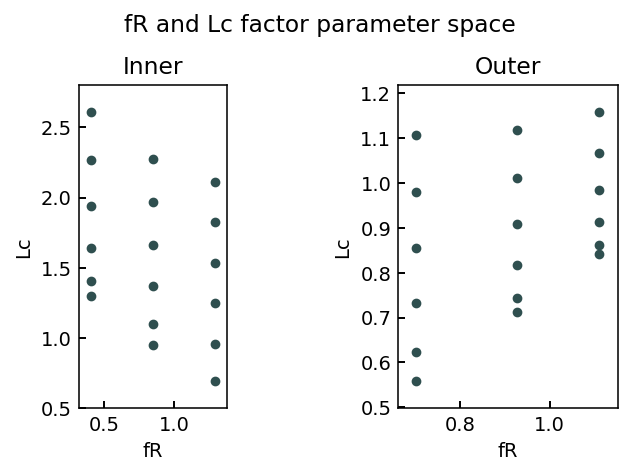

In [18]:
profiles = profiles_constBpol

fig, axes = plt.subplots(1,2, figsize=(6,3))

axes[0].set_title("Inner")
for x in xpoints["inner"]:
    for y in ypoints["inner"]:
        fR = profiles["inner"][x][y].get_total_flux_expansion() / base_profile["inner"].get_total_flux_expansion()
        Lc = profiles["inner"][x][y].get_connection_length() / base_profile["inner"].get_connection_length()
        
        axes[0].plot(fR, Lc, marker = "o", lw = 0, ms = 4, color = "darkslategrey")

axes[1].set_title("Outer")
for x in xpoints["outer"]:
    for y in ypoints["outer"]:
        fR = profiles["outer"][x][y].get_total_flux_expansion() / base_profile["outer"].get_total_flux_expansion()
        Lc = profiles["outer"][x][y].get_connection_length() / base_profile["outer"].get_connection_length()
        
        axes[1].plot(fR, Lc, marker = "o", lw = 0, ms = 4, color = "darkslategrey")
        

for ax in axes:
    ax.set_xlabel("fR")
    ax.set_ylabel("Lc")
    ax.set_aspect("equal")

fig.suptitle("fR and Lc factor parameter space", y = 1.05)

# Run DLS

In [235]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, hflux_corr=1):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]
    
    # This comes from the SOLPS comparison match for the specific SOL rings
    if "inner" in region:
        qpllu0 = 2.5e8 * 1.1
    else:
        qpllu0 = 3.0e8 * 1.06

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=SparRange,
        qpllu0=qpllu0,
        nu0=nu,
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve(
            "Ar", region, sepadd=sepadd, plot=False
        ),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        Ctol = 1e-4,
        Ttol = 1e-3,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            MagneticGeometry.from_profile(profile),
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Run baseline

## Initialise

In [237]:
store = {}
comps = {}
base = {}

for side in ["outer", "inner"]:
    store[side] = {}
    for curve in ["Curve 1", "SOLPS"]:
        store[side][curve] = {}

### Baseline

In [238]:
# for side in ["inner"]:
for side in ["inner", "outer"]:

    region = f"{side}_lower"
    base[side] = {}

    for curve in ["Curve 1", "SOLPS"]:

        base_profile[side] = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
        SparRange = make_SparRange(base_profile[side], mode = "target_and_xpoint")
        
        input = dict(cooling_curve = curves[f"set_{side}"][curve])
        out, comp = run_DLS(input, base_profile[side], SparRange, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        base[side][curve] = out
        

Solving...0.00...11.57...Complete in 4.8 seconds
Solving...0.00...11.57...Complete in 8.0 seconds
Solving...0.00...16.06...Complete in 5.3 seconds
Solving...0.00...16.06...Complete in 6.6 seconds


## Study function

In [239]:
def run_study(side, region, curve, profiles):
    store_out = {}
    for x in xpoints[side]:
        store_out[x] = {}
        for y in ypoints[side]:
            print(f"Solving profile {x:.2f}, {y:.2f} ------")
            input = dict(cooling_curve=curves[f"set_{side}"][curve], Ctol=Ctol, Ttol=Ttol)
            profile = profiles[side][x][y]
            SparRange = make_SparRange(profile, mode = "target_and_xpoint")
            out, comp = run_DLS(
                input,
                profile,
                SparRange,
                store_slc[case],
                "density",
                region,
                sepadd_select[region],
                hflux_corr=1,
            )
            store_out[x][y] = out
            
    return store_out

# Run all

In [240]:
for side in ["outer", "inner"]:
    print(    f"\n-------------------------------------Running {side}-------------------------------------")
    for curve in ["Curve 1", "SOLPS"]:
        print(f"\n-------------------------------------{curve}-------------------------------------")
        store[side][curve] = run_study(side, f"{side}_lower", curve, profiles_constBpol)



-------------------------------------Running outer-------------------------------------

-------------------------------------Curve 1-------------------------------------
Solving profile 2.00, -4.65 ------
Solving...0.00...1.16...Complete in 4.9 seconds
Solving profile 2.00, -4.91 ------
Solving...0.00...2.28...Complete in 6.1 seconds
Solving profile 2.00, -5.17 ------
Solving...0.00...3.91...Complete in 5.3 seconds
Solving profile 2.00, -5.42 ------
Solving...0.00...5.62...Complete in 5.4 seconds
Solving profile 2.00, -5.68 ------
Solving...0.00...7.36...Complete in 5.6 seconds
Solving profile 2.00, -5.94 ------
Solving...0.00...9.11...Complete in 5.5 seconds
Solving profile 2.00, -6.20 ------
Solving...0.00...10.88...Complete in 4.8 seconds
Solving profile 2.00, -6.45 ------
Solving...0.00...12.65...Complete in 5.0 seconds
Solving profile 2.00, -6.71 ------
Solving...0.00...14.42...Complete in 5.1 seconds
Solving profile 2.00, -6.97 ------
Solving...0.00...16.20...Complete in 5.4 se

# Save/Load

In [241]:
write_file(store, "strikepoint_opt_sensitivity.dill")

strikepoint_opt_sensitivity.dill written


In [ ]:
store_inner = read_file("strikepoint_opt_sensitivity.dill")

dict_keys([1.9, 3.2, 4.5])

# Sensitivity calcs

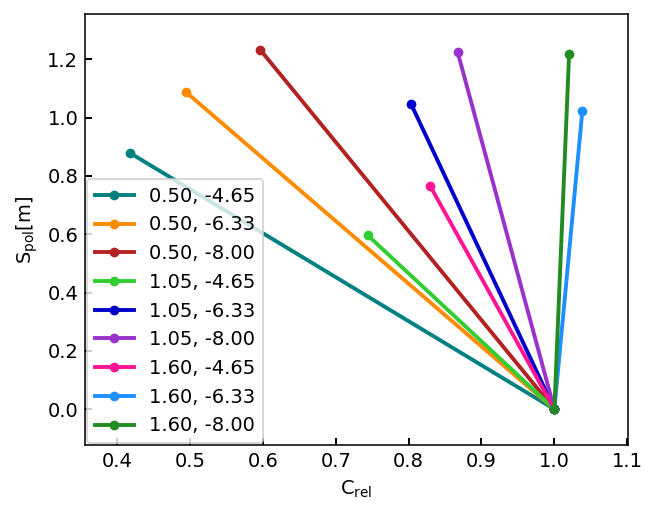

In [167]:
from cycler import cycler
fig, ax = plt.subplots()
default_cycler = cycler(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])


with plt.rc_context({'axes.prop_cycle': default_cycler}):
    for x in xpoints_inner:
        for y in ypoints_inner:
            store = store_inner["Curve 1"][x][y]
            deck = FrontLocationScan(store)
            deck.plot_front_movement(ax = ax, label = f"{x:.2f}, {y:.2f}", relative = True)
            # ax.scatter(deck.data["crel_stable"], deck.data["Spol"], c = "k", marker = "x")
            # deck.get_stable_region(diagnostic_plot = True)

    ax.legend()

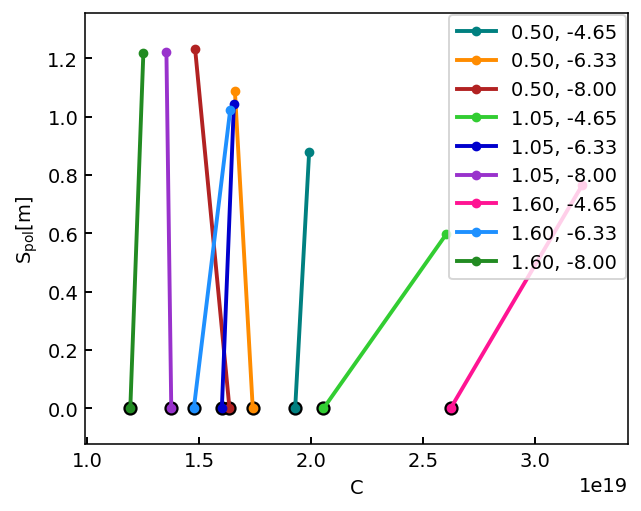

In [220]:
from cycler import cycler
fig, ax = plt.subplots()
default_cycler = cycler(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])


with plt.rc_context({'axes.prop_cycle': default_cycler}):
    for x in xpoints_inner:
        for y in ypoints_inner:
            store = store_inner["SOLPS"][x][y]
            deck = FrontLocationScan(store)
            deck.plot_front_movement(ax = ax, label = f"{x:.2f}, {y:.2f}", relative = False)
            
            store2 = store_inner["SOLPS2"][x][y]
            ax.scatter(store2["cvar"],[0], c = "k", s = 40)
            # ax.scatter(deck.data["crel_stable"], deck.data["Spol"], c = "k", marker = "x")
            # deck.get_stable_region(diagnostic_plot = True)

    ax.legend()

# Make arrays for 2D plots

In [83]:
store_inner["Curve 1"][1.6][-4.65].keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Sprofiles', 'Tprofiles', 'Rprofiles', 'Qprofiles', 'Spolprofiles', 'Btotprofiles', 'Bpolprofiles', 'Xpoints', 'Wradials', 'logs', 'spar_onset', 'spol_onset', 'splot', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_frac', 'window_ratio', 'constants', 'radios', 'state', 'runtime'])

In [242]:

def make_contourf_arrays(study, store_results, store_base, xpoints, ypoints):
    study_shape = (len(xpoints), len(ypoints))
    decks = nested_dict()
    basecase = FrontLocation(store_base)

    arrays = {}

    for param in [
        "BxBt",
        "Lc",
        "thresholds",
        "BxBt_relative",
        "Lc_relative",
        "thresholds_relative",
        "unstable_Lpol_backward",
        "window_ratio",
    ]:
        arrays[param] = np.zeros(study_shape)

    for i, x in enumerate(xpoints):
        for j, y in enumerate(ypoints):
            deck = FrontLocationScan(store_results[x][y])
            threshold = FrontLocation(store_results[x][y], index = 0)
            # threshold = deck.FrontLocations[0]

            # decks[x][y] = deck

            arrays["BxBt"][i,j] = threshold.stats["BxBt"]
            arrays["Lc"][i,j] = threshold.stats["cvar"]
            arrays["thresholds"][i,j] = threshold.stats["Lc"]
            arrays["BxBt_relative"][i,j] = (
                threshold.stats["BxBt"] / basecase.stats["BxBt"]
            )
            arrays["Lc_relative"][i,j] = threshold.stats["Lc"] / basecase.stats["Lc"]
            arrays["thresholds_relative"][i,j] = (
                threshold.stats["cvar"] / basecase.stats["cvar"]
            )
            # arrays["unstable_Lpol_backward"][j, i] = deck.unstable_Lpol_backward
            arrays["window_ratio"][i,j] = deck.window_ratio
            
    for name, array in arrays.items():
        arrays[name] = array.T

    return arrays


arrays = {}

for side in ["inner", "outer"]:
    arrays[side] = {}
    print(f"Found {store[side].keys()} for {side}")
    for curve in store[side].keys():
        arrays[side][curve] = make_contourf_arrays(
            side, store[side][curve], base[side][curve], xpoints[side], ypoints[side]
        )


Found dict_keys(['Curve 1', 'SOLPS']) for inner
Found dict_keys(['Curve 1', 'SOLPS']) for outer


In [102]:
store["outer"].keys()

dict_keys(['SOLPS'])

In [231]:
study_shape = (len(xpoints["inner"]), len(ypoints["inner"]))
thresh1 = np.zeros(study_shape)
thresh2 = np.zeros(study_shape)

for i, x in enumerate(xpoints["inner"]):
    for j, y in enumerate(ypoints["inner"]):
        # thresh1[i,j] = store_inner["SOLPS"][x][y]["cvar"][0]
        # thresh2[i,j] = store_inner["SOLPS2"][x][y]["cvar"][0]
        
        thresh1[i,j] = FrontLocation(store_inner["SOLPS"][x][y], index = 0).stats["cvar"]
        thresh2[i,j] = FrontLocation(store_inner["SOLPS2"][x][y], index = 0).stats["cvar"]
        
        
print(thresh1)
print(thresh2)

[[1.92892615e+19 1.73949538e+19 1.63547062e+19]
 [2.05519524e+19 1.60128245e+19 1.37525798e+19]
 [2.62315840e+19 1.47605990e+19 1.19215106e+19]]
[[1.92892615e+19 1.73949538e+19 1.63547062e+19]
 [2.05519524e+19 1.60128245e+19 1.37525798e+19]
 [2.62315840e+19 1.47605990e+19 1.19215106e+19]]


# 2D plots

## Contour function

In [243]:
def make_contour(ax, xpoints, ypoints, array, datarange, step, cmap = "Pastel1", cbar = True, step_mult = 1, breakpoint_line = True, extend = "neither", breakpoint_kwargs={}, line_kwargs={}):
    
    levels = np.arange(datarange[0], datarange[1] + step, step) - step/2
    levels_for_ticks = np.arange(datarange[0], datarange[1] + step*step_mult, step*step_mult) - step*step_mult/2
    ticks = levels_for_ticks[:-1] + (step * step_mult) / 2  # Midpoints of each segment

    cf = ax.contourf(xpoints, ypoints, array, levels = levels, cmap = cmap, norm = create_norm(False, None, *datarange), antialiased = True, extend = extend)
    ax.contour(xpoints, ypoints, array, levels = levels,norm = create_norm(False, None, *datarange), antialiased = True, **{**dict(colors = "black", linewidths = 0.25, alpha =0.25), **breakpoint_kwargs})
    
    if breakpoint_line:
        ax.contour(xpoints, ypoints, array, levels = [1], **{**dict(colors = "darkslategrey", linewidths = 1.0, linestyles = "--"), **breakpoint_kwargs})
    if cbar:
        cbar = fig.colorbar(cf, ax = ax)
        cbar.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x)))
        cbar.set_ticks(ticks)

    ax.set_aspect("equal")
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    ax.grid(False)
    
def format_axes(axes):
    for ax in axes:
        base_profile["inner"].plot(mode = "RZ", ax = ax, color = "deeppink")
        base_profile["outer"].plot(mode = "RZ", ax = ax, color = "deeppink")
        ax.set_aspect("equal")
        ax.set_xlabel("R [m]")
        ax.set_ylabel("Z [m]")
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
        ax.set_ylim(-8, -4.7)
        ax.set_xlim(0.5, 4.5)
        
    return axes

# fR, Lc 

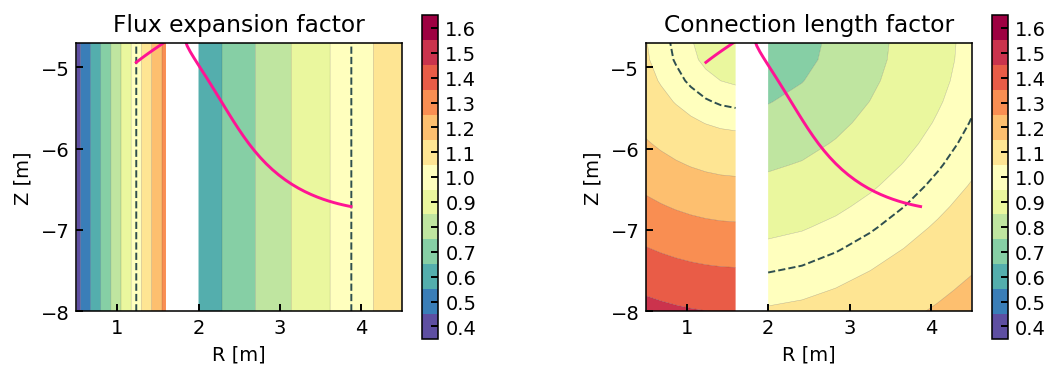

In [244]:
fig, axes = plt.subplots(1,2, figsize = (9,3))

cmap = "Spectral_r"
study = "Curve 1"
datarange = (0.4, 1.6)
step = 0.1

axes[0].set_title("Flux expansion factor")
make_contour(ax = axes[0], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Curve 1"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Curve 1"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes[1].set_title("Connection length factor")
make_contour(ax = axes[1], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Curve 1"]["Lc_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Curve 1"]["Lc_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes = format_axes(axes)

fig.subplots_adjust(wspace = 0.4)

## Threshold

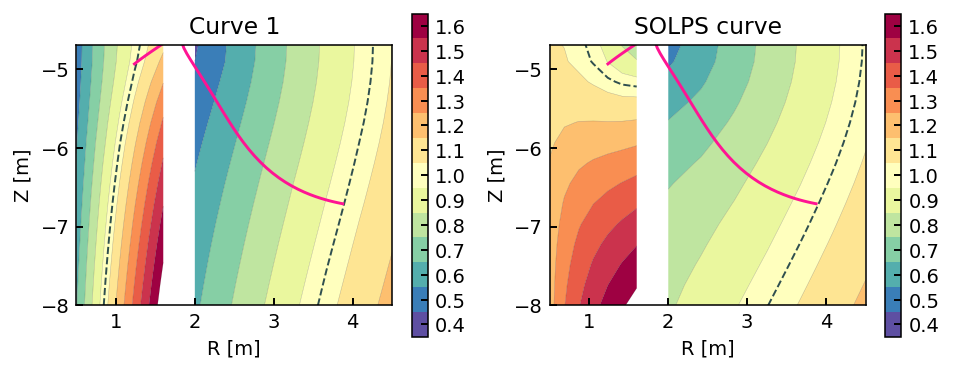

In [245]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

cmap = "Spectral_r"
study = "Curve 1"
datarange = (0.4, 1.6)
step = 0.1

axes[0].set_title("Curve 1")
make_contour(ax = axes[0], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes[1].set_title("SOLPS curve")
make_contour(ax = axes[1], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes = format_axes(axes)
fig.subplots_adjust(wspace = 0.2)

## Window

In [128]:
arrays_outer.keys()

dict_keys([])

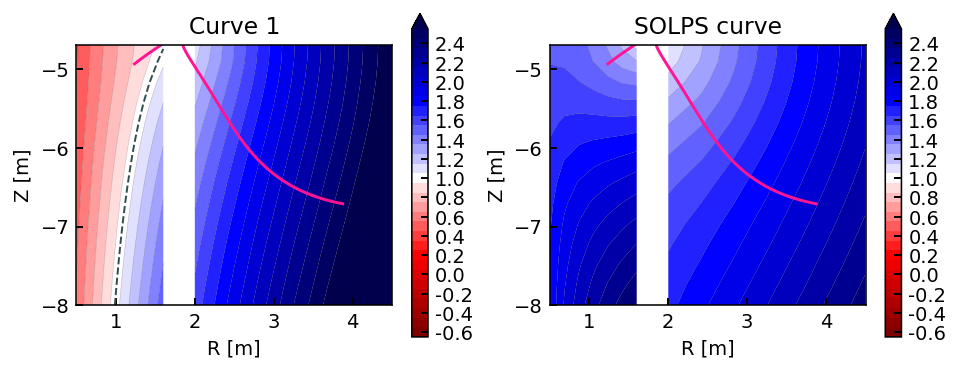

In [246]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

cmap = "seismic_r"
study = "Curve 1"
extent = 1.6
datarange = (1-extent, 1+extent)
step = 0.1

kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")

axes[0].set_title("Curve 1")
make_contour(ax = axes[0], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Curve 1"]["window_ratio"], **kwargs)
make_contour(ax = axes[0], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Curve 1"]["window_ratio"], cbar = False, **kwargs)

axes[1].set_title("SOLPS curve")
make_contour(ax = axes[1], xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["SOLPS"]["window_ratio"], **kwargs)
make_contour(ax = axes[1], xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["SOLPS"]["window_ratio"], cbar = False, **kwargs)

axes = format_axes(axes)
fig.subplots_adjust(wspace = 0.2)

256.00229335620685

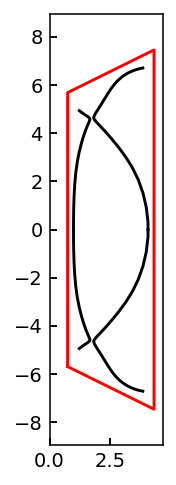

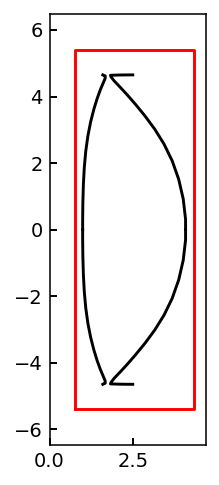

In [168]:
inner_profile = base_profile["inner"]
outer_profile = base_profile["outer"]
# inner_profile = profiles_constBpol["inner"][1.6][-4.65]
# outer_profile = profiles_constBpol["outer"][2.5][-4.65]


def get_coil_volume(inner_profile, outer_profile, plot = False):
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(inner_profile["R"], inner_profile["Z"], c = "k", lw = 1.5)
        ax.plot(inner_profile["R"], -inner_profile["Z"], c = "k", lw = 1.5)
        ax.plot(outer_profile["R"], outer_profile["Z"], c = "k", lw = 1.5)
        ax.plot(outer_profile["R"], -outer_profile["Z"], c = "k", lw = 1.5)

    outer_max_height = -np.min(outer_profile["Z"]) + 0.75
    inner_max_height = -np.min(inner_profile["Z"]) + 0.75
    outer_max_radius = np.max(outer_profile["R"])
    IR = 0.75
    OR = outer_max_radius + 0.25

    pol = shapely.geometry.Polygon([
        (IR, -inner_max_height),
        (IR, inner_max_height),
        (OR, outer_max_height),
        (OR, -outer_max_height)
    ])
    x, y = pol.exterior.xy
    
    if plot:
        ax.plot(x, y, c = "r")
        ax.set_aspect("equal")
        ax.set_xlim(0, None)

    sorted_coords = sorted(zip(y, x))
    y_sorted, x_sorted = zip(*sorted_coords)

    # Define a function to compute the volume of revolution using the method of disks
    def revolved_volume(y, x):
        volume = 0
        for i in range(1, len(y)):
            r1 = x[i-1]
            r2 = x[i]
            h = y[i] - y[i-1]
            volume += np.pi * h * (r1**2 + r1*r2 + r2**2) / 3
        return volume

    # Compute the revolved volume
    volume = revolved_volume(y_sorted, x_sorted)
    
    return volume

get_coil_volume(base_profile["inner"], base_profile["outer"], plot = True)
get_coil_volume(profiles_constBpol["inner"][1.6][-4.65], outer_profile = profiles_constBpol["outer"][2.5][-4.65]
, plot = True)

104.11206048397008

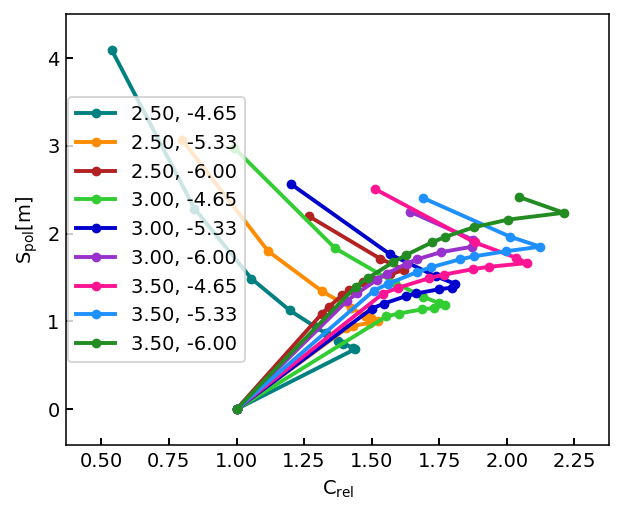

In [48]:
from cycler import cycler
fig, ax = plt.subplots()
default_cycler = cycler(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])

side = "outer"
with plt.rc_context({'axes.prop_cycle': default_cycler}):
    for x in xpoints[side]:
        for y in ypoints[side]:
            deck = FrontLocationScan(store[side]["Curve 1"][x][y])
            deck.plot_front_movement(ax = ax, label = f"{x:.2f}, {y:.2f}", relative = True)
            # ax.scatter(deck.data["crel_stable"], deck.data["Spol"], c = "k", marker = "x")
            # deck.get_stable_region(diagnostic_plot = True)

    ax.legend()

In [52]:
profiles_constBpol["outer"][3.50].keys()

dict_keys([-4.65, -5.325, -6.0])

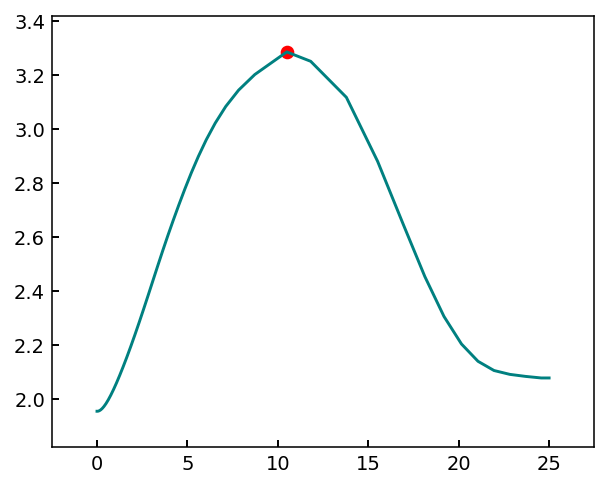

In [57]:
p = profiles_constBpol["outer"][3.50][-5.325]
deck = FrontLocationScan(store["outer"]["Curve 1"][3.50][-5.325])

fig, ax = plt.subplots()
ax.plot(p["S"], p["Btot"])
ax.scatter(p["S"][p["Xpoint"]], p["Btot"][p["Xpoint"]], c = "r")

# profiles_constBpol["outer"][3.50][-5.325].plot(mode = "Btot")

Text(0.5, 1.05, 'Radiated power, parallel heat flux and temperature for two front positions')

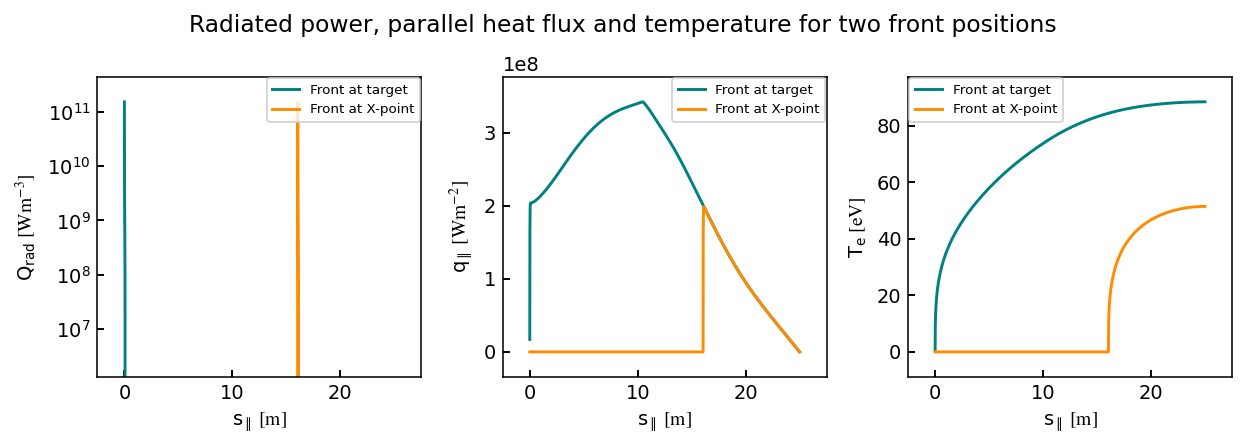

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
labels = ["Front at target", "Front at X-point"]

## Plot 1D profiles along field line for the first and final front solution in the scan
for i, position_index in enumerate([0, -1]):
    front_solution = deck.FrontLocations[position_index]

    axes[0].plot(
        front_solution.data["Spar"],
        front_solution.data["Qrad"],
        label=labels[i],
    )

    axes[1].plot(
        front_solution.data["Spar"],
        front_solution.data["qpar"],
        label=labels[i],
    )
    axes[2].plot(
        front_solution.data["Spar"],
        front_solution.data["Te"],
        label=labels[i],
    )

axes[0].set_ylabel(r"$Q_{rad}\ \mathrm{[Wm^{-3}]}$")
axes[1].set_ylabel(r"$q_{\parallel}\ \mathrm{[Wm^{-2}]}$")
axes[2].set_ylabel(r"$T_{e}\ \mathrm{[eV]}$")
axes[0].set_yscale("log")
for ax in axes:
    ax.set_xlabel(r"$s_{\parallel}\ \mathrm{[m]}$")
    ax.legend(fontsize="x-small")

fig.tight_layout()
fig.suptitle(
    "Radiated power, parallel heat flux and temperature for two front positions", y=1.05
)

## Sensitivity

NameError: name 'xpoints_inner' is not defined

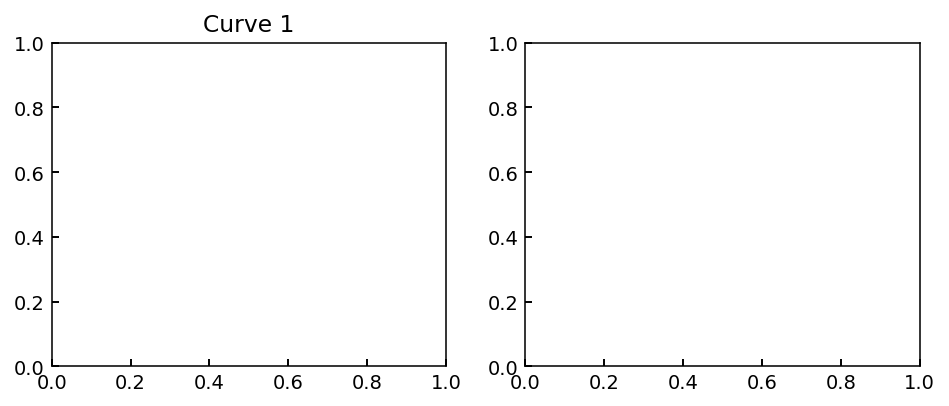

In [178]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

cmap = "RdBu"
study = "Curve 1"
datarange = (0.2, 2.2)
step = 0.2

axes[0].set_title("Curve 1")
# make_contour(ax = axes[0], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints_inner, ypoints=ypoints_inner, array = arrays_inner["Curve 1"]["window_ratio"], datarange = datarange, step = step, cmap = cmap, cbar = True)

axes[1].set_title("SOLPS curve")
# make_contour(ax = axes[1], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints_inner, ypoints=ypoints_inner, array = 1/arrays_inner["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = True)

for ax in axes:
  base_profile_inner.plot(mode = "RZ", ax = ax, color = "black")
  base_profile_outer.plot(mode = "RZ", ax = ax, color = "black")
  ax.set_aspect("equal")
  ax.set_xlabel("R [m]")
  ax.set_ylabel("Z [m]")
  ax.set_ylim(-8, -4.7)
  ax.set_xlim(0.5, 4.5)
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
  # ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
  # ax.grid(which = "minor", c = "k", alpha = 0.05)
fig.subplots_adjust(wspace = 0.2)

